# Desafio Quantamental Itaú 2021

## Objetivo do desafio

<cite>A forma mais fácil de entender o objetivo do desafio é se colocar na posição de um
analista quantitativo de um fundo de investimento.
Seu objetivo é criar e apresentar uma estratégia quantitativa de investimento e,
assim, convencer o gestor do fundo a colocá-la no portfólio ou, pelo menos,
considerar a possibilidade de saber mais sobre sua proposta, aprofundando seu
entendimento.
Portanto, sugerimos utilizar uma linguagem mais prática e direta, evitando uma
comunicação acadêmica.
**O objetivo é apresentar a sua ideia para o gestor do fundo e não escrever um 
artigo acadêmico.** </cite>

## Abordagem Utilizando Aprendizado de maquina

$\quad$Técnicas de aprendizado de máquina ganharam notoriedade por conseguirem resultados promissores em diversas áreas. Isso se deve pelo volume de dados e pelo aumento do processamento dos computadores. \
$\quad$O mercado financeiro não foi uma exceção, também adotou essas técnicas. Com o crescimento de fundos quantitativos, cada vez mais empresas empregam o uso de aprendizado de máquina para identificação de tendências do mercado e gerenciamento de portfólio. \
$\quad$O objetivo da ideia de investimento apresentada neste trabalho é uma tentativa de empregar o uso do aprendizado supervisionado na identificação de tendências de mercado de uma ação. Para tal, os valores de fechamento de ações diários foram discretizados e transformados em um problema de classificação.


## De onde a ideia foi tirada?

$\quad$A ideia de classificação dos dados foi baseada no livro “Advances in Financial Machine Learning” (2018), de Marcos López de Prado. Utilizei um algoritmo parecido com o do livro, mas com uma implementação adaptada para dados com intervalos diários. A adaptação foi pensada como uma implementação da barreira tripla do código, a partir do artigo “Data Labelling: The Triple-barrier Method” (Gui, 2020). Após a classificação, utilizei técnicas conhecidas de aprendizado de máquina. <br>

## Dados

$\quad$Na literatura revisada sobre análise de dados financeiros para modelos de aprendizado de máquina, me deparei com alguns possíveis casos de modelagem de dados. Usualmente tem-se uma tabela com informações de ações nas colunas e agrupamentos de períodos de tempo nas linhas. Quando nos aproximamos dos dados mais crus, encontramos as entradas de compras e vendas nas linhas com seus respectivos horários - denominaremos essas linhas como “barras de tempo”. Destaco a representação dos dados mais comuns para poder ressaltar um erro muito usual em modelos financeiros de aprendizado de máquina.

### Barras de tempo

$\quad$É a representação de dados que mais encontramos. Os dados são disponibilizados de acordo com um intervalo de tempo, podendo ser minutos, horas, dias etc. \
$\quad$Apesar de sua utilização ser muito popular, esse tipo de representação deve ser evitada pois o mercado não processa a informação em um tempo constante. O horário em que o mercado abre, por exemplo, tem uma atividade mais intensa do que  por volta do meio-dia. Isso significa que por volta do meio-dia, ou seja, no período de baixa atividade, as barras de tempo terão pouca frequência de informação, enquanto que no momento de abertura do mercado, ou seja, no período de alta atividade, terão alta frequência de informação. Essa inconstância na frequência de informações ocasiona um desbalanceamento da frequência dos dados.\
$\quad$Para podermos contornar esse problema precisamos de dados mais “crus”, com a informação do horário em que ocorreu o trade, o seu preço, a quantidade e se foi uma venda ou compra. No presente trabalho não temos um intervalo de tempo agrupando os trades, e sim um fluxo natural dos dados do mercado. Isso é devido à difícil obtenção destes dados de forma gratuita, ainda mais para um histórico longo. Quando podem ser encontrados de forma gratuita, esses dados contêm apenas alguns dias ou, no máximo, alguns meses. Dessa forma, apesar de não ser o ideal, optou-se por utilizar dados de barra de tempo, por serem encontrados de forma gratuita e em um volume maior, o que é essencial para podermos treinar um modelo de aprendizado de máquina.\
$\quad$Os dados que utilizei foram extraídos do Yahoo Finance. A API construída para o python nos permite apenas extrair dados diários. Esbarramos aqui em outro problema: analogamente aos dados, imagine que os dados diários são uma imagem com péssima resolução, com uma distância muito grande entre os pixels, o que dificulta uma análise mais precisa da imagem. O ideal seria menor tempo de intervalo dos dados, o que significaria maior resolução e qualidade da imagem, e assim seria possível conclusões com uma precisão muito maior. Contudo, acabamos por utilizar os dados diários devido a falta de acesso à dados com uma frequência de minutos ou horas de forma gratuita e em grande volume.\
$\quad$Os dados diários foram extraídos do período indicado no desafio, de 30-12-2009 até 31-12-2020. Cada dia é uma linha e as colunas são as variáveis de abertura de preço, seu valor mais alto, mais baixo, preço de fechamento. A ação escolhida foi a do Itaú (ITUB4.SA).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import pandas_ta as ta

plt.style.use('fivethirtyeight')

In [5]:
ticker = 'ITUB4.SA'
yfObj = yf.Ticker(ticker)
data = yfObj.history(start="2009-12-30", end="2020-12-31")
data.drop(columns = ['Dividends', 'Stock Splits'], inplace = True)
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2009-12-30,10.888960,11.030743,10.840754,10.971194,8940087
2010-01-04,11.027909,11.481616,11.027909,11.376697,11843397
2010-01-05,11.405057,11.450428,11.314316,11.450428,8593315
2010-01-06,11.413557,11.481614,11.257596,11.351173,10602572
2010-01-07,11.271773,11.356844,11.215060,11.234911,9966567


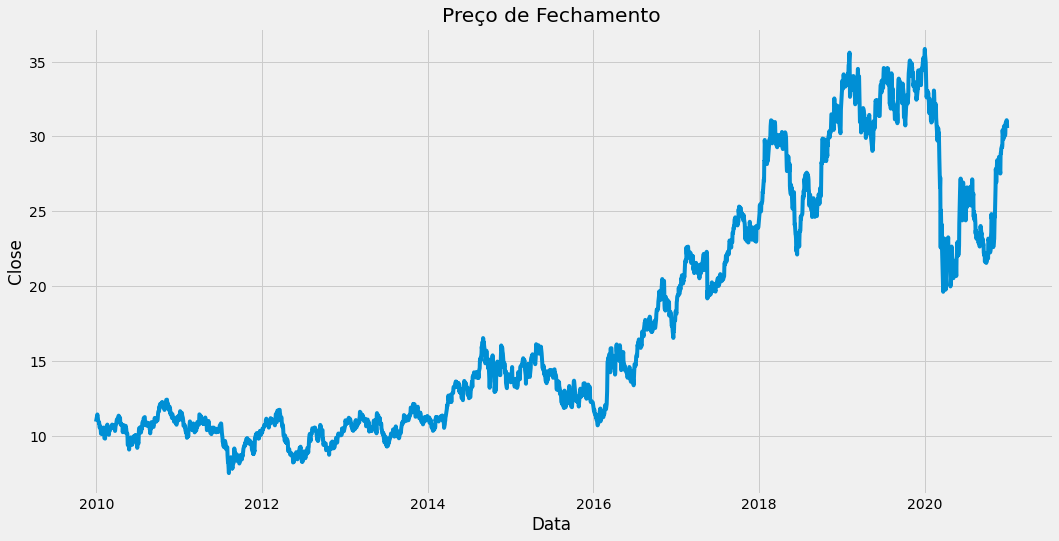

In [8]:
plt.figure(figsize=(16,8))
plt.title('Preço de Fechamento')
plt.plot(data.Close)
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

num_time_bars = len(data)

## Indicadores do Mercado

$\quad$Alguns indicadores foram criados a partir dos dados obtidos, como RSI, MACD, bbands, médias móveis, preço médio ponderado por volume (VWAP) e ATR (Average True Range). \
$\quad$O objetivo é escolher indicadores que possam indicar tendências do mercado, em razão do nosso modelo ter o intuito de aprender a classificar a partir desses dados.\


In [11]:
#MA indicator
def SMA(values, n):
    """
    Retorna media movel n de values
    """
    return pd.Series(values).rolling(n).mean()


def cross_over(data, sma1, sma2):
    sinal = []
    n = len(data)
    
    for i in range(n):
        if (i < n2 -2):
            sinal.append(0)
        elif (sma1[i-2] < sma2[i-2] and sma1[i-1] > sma2[i-1]):
            sinal.append(1)
        elif (sma1[i-2] > sma2[i-2] and sma1[i-1] < sma2[i-1]):
            sinal.append(-1)
        else:
            sinal.append(sinal[i-1])
    return sinal

#media movel curta
n1 = 10
#media movel longa
n2 = 30
sma1 = SMA(data.Close, n1)
sma2 = SMA(data.Close, n2)

sma1.fillna(0, inplace = True)
sma2.fillna(0, inplace = True)

data['cross_over'] = cross_over(data, sma1, sma2)

def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    #bollinger bands com a media
    TP = (data.High + data.Low + data.Close) / 3
    std = TP.rolling(n_lookback).std() 
    MA = TP.rolling(n_lookback).mean()
    upper = TP + n_std*std
    lower = TP - n_std*std
    
    return upper, lower

def tec_indicators(data):
    data['vwap'] = data.ta.vwap()
    #average true range
    data['atr'] = data.ta.atr()
    #Bbands
    data['upper'], data['lower'] = BBANDS(data, 20, 2)
    #Rsi
    data['rsi'] = data.ta.rsi(close='Close', lenght = 2)
    macd = data.ta.macd(fast = 8, slow = 21)
    data = pd.concat([data, macd], axis = 1)
    
    data['SMA_15'] = pd.Series(data.Close).rolling(20).mean()
    #data['SMA_50'] = pd.Series(data.Close).rolling(50).mean()
    data['SMA_100'] = pd.Series(data.Close).rolling(100).mean()
    
    return data

In [12]:
data = tec_indicators(data)
data.head()

,Open,High,Low,Close,Volume,cross_over,vwap,atr,upper,lower,rsi,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,SMA_15,SMA_100
Date,,,,,,,,,,,,,,,,
2009-12-30,10.888960,11.030743,10.840754,10.971194,8940087,0,10.947564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,11.027909,11.481616,11.027909,11.376697,11843397,0,11.295407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,11.405057,11.450428,11.314316,11.450428,8593315,0,11.405057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,11.413557,11.481614,11.257596,11.351173,10602572,0,11.363461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,11.271773,11.356844,11.215060,11.234911,9966567,0,11.268939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Linhas duplicadas

In [13]:
nLinhas , nColunas = data.shape

dupl = data.duplicated().sum()/nLinhas

print('Porcentagem de linhas duplicadas:', round(dupl*100,2))

Porcentagem de linhas duplicadas: 0.0


Porcentagem de nan

In [14]:
#Verificado a quantidade de NaN por atributo
nan_train= pd.DataFrame()
nan_train['Qtd Nan'] = data.isna().sum()
nan_train['Qtd Nan %'] = round(100*data.isna().sum()/len(data),2)
print('Frequencia treino:')
nan_train.head(30)

Frequencia treino:


,Qtd Nan,Qtd Nan %
Open,0,0.00
High,0,0.00
Low,0,0.00
Close,0,0.00
Volume,0,0.00
cross_over,0,0.00
vwap,34,1.25
atr,14,0.51
upper,19,0.70
lower,19,0.70


Porcentagem de dados igual a 0

In [15]:
(data == 0).astype(int).sum(axis=0)/len(data)*100

Open            0.000000
High            0.000000
Low             0.000000
Close           0.000000
Volume          1.247249
cross_over      1.100514
vwap            0.000000
atr             0.000000
upper           0.000000
lower           0.000000
rsi             0.000000
MACD_8_21_9     0.000000
MACDh_8_21_9    0.000000
MACDs_8_21_9    0.000000
SMA_15          0.000000
SMA_100         0.000000
dtype: float64

## Variável a ser predita

$\quad$Para podermos treinar um modelo de aprendizado de máquina supervisionado precisamos da variável que queremos prever. O preço das ações do mercado tem um comportamento estocástico, e, portanto, tem seu estado indeterminado. Assim, vamos utilizar a estratégia do de Prado (2018), chamada de método de barreira tripla. \
$\quad$Antes disso, cito o modelo mais encontrado na literatura e o porquê dele não ter um resultado eficaz

### Método de horizonte
Nesse método calculamos o retorno do preço em n dias e classificamos a sua predição utilizando uma constante, sendo o retorno definido por: \

$$\frac{p_1 - p_2}{p_2}$$
p1: preço atual \
p2: preço anterior a n intervalos de tempo \
 
| 1  | Retorno >= Constante              |
|----|-----------------------------------|
| -1 | Retorno <= Constante              |
| 0  | - Constante < Retorno < Constante |

O grande problema dessa abordagem é não considerar a volatilidade dos preços ao atribuir a constante


### Método de Barreira Tripla

$\quad$Nesse método temos a construção de uma barreira tripla. A sua grande vantagem está em considerar a volatilidade para classificarmos cada linha da nossa tabela de acordo com a barreira que o preço de fechamento atingiu primeiro. \
$\quad$Uma abordagem desse método seria considerar transações apenas de long. A barreira superior será o limite de lucro que iremos obter antes de sair, a barreira inferior será o stop loss, e a barreira vertical, o tempo limite que seguramos uma ação.\ 
$\quad$Entretanto, queremos um modelo que trate tanto de long quanto short. Dessa forma, optei por uma outra abordagem possível, na qual vamos classificar como uma operação de venda quando o preço futuro atingir a barreira inferior; compra quando atingir a barreira superior, e saímos da posição atual caso atingimos a barreira lateral. Fazemos isso pois nosso modelo está tentando prever tendências no futuro e, assim, quando ele estiver prevendo uma queda ou compra queremos apostar nisso. \
$\quad$Utilizei 10 dias futuros para a construção da barreira vertical, e 2 como multiplicador tanto da barreira superior quanto inferior.\

**Barreira horizontal superior:** Preço futuro + volatilidade de n intervalos de tempo anterior\
**Barreira horizontal inferior:** Preço futuro - volatilidade de n intervalos de tempo anterior\
**Barreira vertical:** temos a opção de atribuir 0 ou o sinal do retorno, optamos por 0

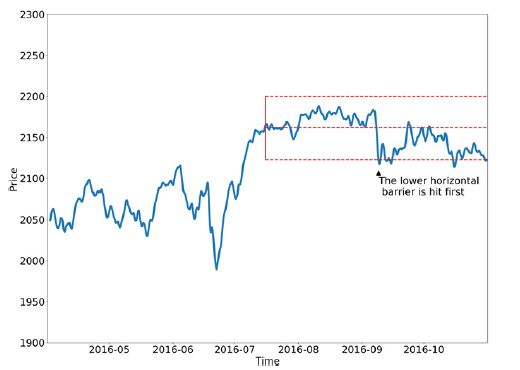

In [19]:
def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0

def get_3_barriers():
    #create a container
    barriers = pd.DataFrame(columns=['days_passed', 
              'price', 'vert_barrier', \
              'top_barrier', 'bottom_barrier'], \
               index = daily_volatility.index)
    for day, vol in daily_volatility.iteritems():
        days_passed = len(daily_volatility.loc \
                      [daily_volatility.index[0] : day])
        #set the vertical barrier 
        if (days_passed + t_final < len(daily_volatility.index) \
            and t_final != 0):
            vert_barrier = daily_volatility.index[
                                days_passed + t_final]
        else:
            vert_barrier = np.nan
        #set the top barrier
        if upper_lower_multipliers[0] > 0:
            top_barrier = prices.loc[day] + prices.loc[day] * \
                          upper_lower_multipliers[0] * vol
        else:
            #set it to NaNs
            top_barrier = pd.Series(index=prices.index)
        #set the bottom barrier
        if upper_lower_multipliers[1] > 0:
            bottom_barrier = prices.loc[day] - prices.loc[day] * \
                          upper_lower_multipliers[1] * vol
        else: 
            #set it to NaNs
            bottom_barrier = pd.Series(index=prices.index)
        barriers.loc[day, ['days_passed', 'price','vert_barrier','top_barrier', 'bottom_barrier']] = days_passed, prices.loc[day], vert_barrier, top_barrier, bottom_barrier
    return barriers

In [20]:
price = data.Close
#set the boundary of barriers, based on 20 days EWM
daily_volatility = get_Daily_Volatility(price)
# how many days we hold the stock which set the vertical barrier
t_final = 10 
#the up and low boundary multipliers
upper_lower_multipliers = [2, 2]
#allign the index
prices = price[daily_volatility.index]

In [21]:
barriers = get_3_barriers()
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier
Date,,,,,
2010-01-05,1,11.4504,2010-01-20 00:00:00,11.944,10.9569
2010-01-06,2,11.3512,2010-01-21 00:00:00,11.8726,10.8297
2010-01-07,3,11.2349,2010-01-22 00:00:00,11.7102,10.7596
2010-01-08,4,11.0648,2010-01-26 00:00:00,11.5099,10.6197
2010-01-11,5,10.9684,2010-01-27 00:00:00,11.361,10.5757
...,...,...,...,...,...
2020-12-22,2720,30.1984,NaN,31.2072,29.1897
2020-12-23,2721,30.8652,NaN,31.907,29.8234
2020-12-28,2722,31.0875,NaN,32.0864,30.0885


In [22]:
barriers['out'] = None
barriers.head()

def get_labels():
    '''
    start: first day of the window
    end:last day of the window
    price_initial: first day stock price
    price_final:last day stock price
    top_barrier: profit taking limit
    bottom_barrier:stop loss limt
    condition_pt:top_barrier touching conditon
    condition_sl:bottom_barrier touching conditon
    '''
    for i in range(len(barriers.index)):
        start = barriers.index[i]
        end = barriers.vert_barrier[i]
        if pd.notna(end):
            # assign the initial and final price
            price_initial = barriers.price[start]
            price_final = barriers.price[end]
            # assign the top and bottom barriers
            top_barrier = barriers.top_barrier[i]
            bottom_barrier = barriers.bottom_barrier[i]
            #set the profit taking and stop loss conditons
            condition_pt = (barriers.price[start: end] >= \
             top_barrier).any()
            condition_sl = (barriers.price[start: end] <= \
             bottom_barrier).any()
            #assign the labels
            if condition_pt: #Atingiu barreira superior
                barriers['out'][i] = 1
            elif condition_sl: #Atingiu barreira inferior
                barriers['out'][i] = -1  
            else:  #Atingiu barreira vertical
                barriers['out'][i] = 0
    return
get_labels()
barriers

,days_passed,price,vert_barrier,top_barrier,bottom_barrier,out
Date,,,,,,
2010-01-05,1,11.4504,2010-01-20 00:00:00,11.944,10.9569,-1
2010-01-06,2,11.3512,2010-01-21 00:00:00,11.8726,10.8297,-1
2010-01-07,3,11.2349,2010-01-22 00:00:00,11.7102,10.7596,-1
2010-01-08,4,11.0648,2010-01-26 00:00:00,11.5099,10.6197,-1
2010-01-11,5,10.9684,2010-01-27 00:00:00,11.361,10.5757,-1
...,...,...,...,...,...,...
2020-12-22,2720,30.1984,NaN,31.2072,29.1897,None
2020-12-23,2721,30.8652,NaN,31.907,29.8234,None
2020-12-28,2722,31.0875,NaN,32.0864,30.0885,None


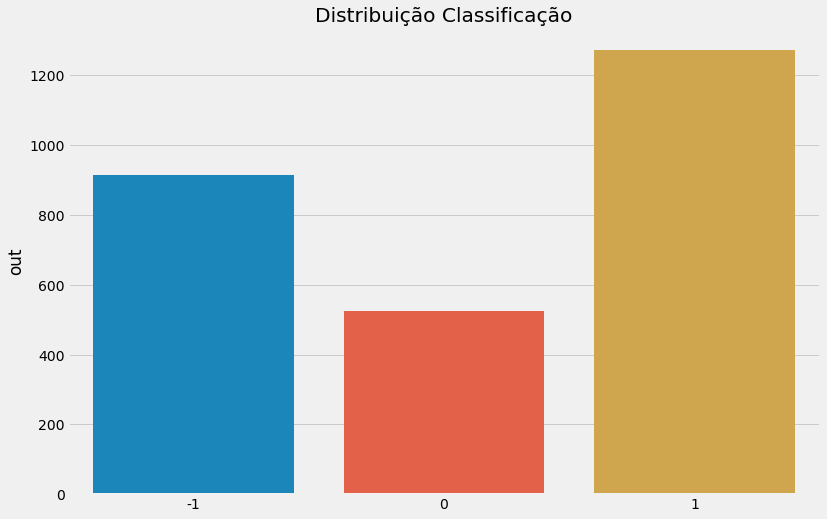

In [24]:
plt.rcParams["figure.figsize"] = (12,8)

sns.barplot(x = barriers.out.value_counts().index, y = barriers.out.value_counts())
plt.title('Distribuição Classificação')
plt.show()

$\quad$O método de barreira tripla rotulou a maioria dos dados como compra (1), seguido de venda (-1) e saída da posição (0), como não ocorreu um grande desbalanceamento, não vamos optar por técnicas de validação estratificadas.

## Analise Exploratoria

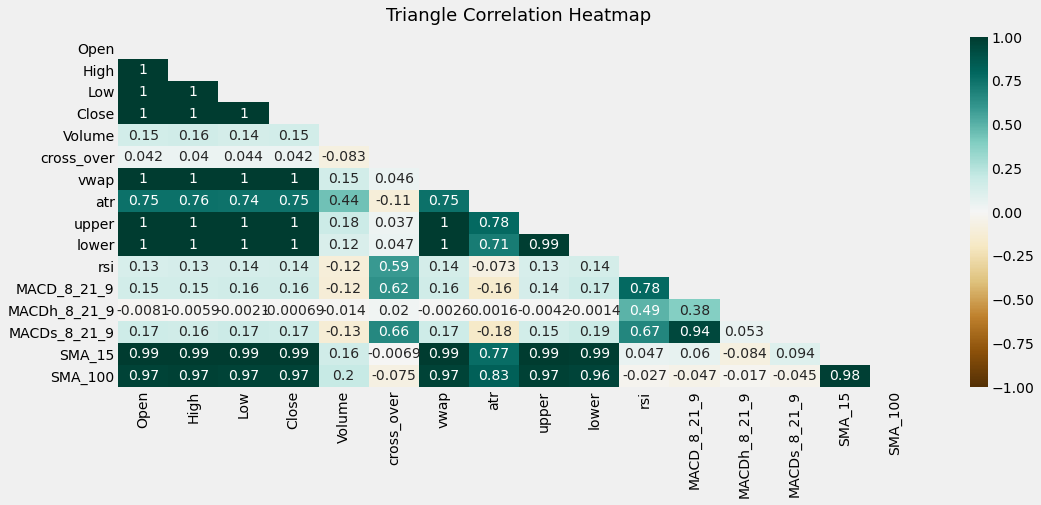

In [26]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(data.corr(), dtype=bool))
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [27]:
df = data.fillna(0)

## Aprendizado Supervisionado

$\quad$Essa etapa é quando realmente entra nossa estratégia de investimento. A ideia final é ter uma função f que para um determinado dia no futuro (x) consiga prever se devemos estar com sinal de compra (1), venda (-1) ou fora da posição (0).\
$\quad$Com os dados e suas respectivas classificações, iremos treinar um modelo de aprendizado supervisionado. Dado nossa matriz de dados (X) e nosso vetor de variáveis a serem preditas Y, nosso objetivo é aprender a função f que leva de X a Y. \
 
 $$f: X \rightarrow Y$$

$\quad$Apliquei quatro modelos de aprendizado nos nossos dados: random forest, SVM, naive bayes e uma variação do ramdom forest para series temporais. Utilizei os modelos das bibliotecas sklearn e pyts do python


In [29]:
out = barriers.out
data['out'] = out
data.out.fillna(0, inplace = True)

df = data.fillna(0)

In [30]:
Y = df.out.to_numpy()

X = df.drop(columns = 'out').to_numpy()

## Validação

$\quad$Utilizei duas estratégias focadas em classificação de series temporais para validar nossos modelos de aprendizado de máquina, sempre tendo o cuidado de deixar um gap de 10 dias entre o treno e o teste, para não termos vazamento de dados futuros, a escolha de 10 dias está baseada na nossa barreira vertical:

### Multiple Train test split

$\quad$Nessa abordagem, dividimos os dados em 4 partes de tamanhos aproximados. Treinamos e testamos nosso modelo na primeira parte, guardando sua acurácia. Entramos então na segunda parte, adicionamos uma quantidade de dados no treino e repetimos o procedimento quatro vezes

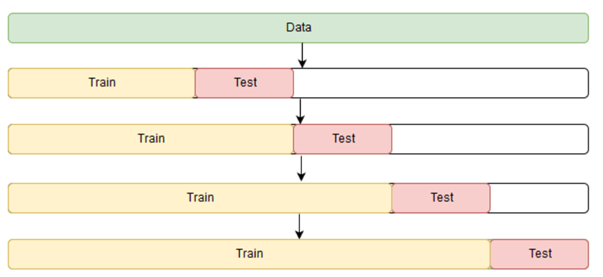

Tiramos uma média das eficácias de cada modelo nas quatro partes

In [32]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from pyts.classification import TimeSeriesForest
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from pyts.classification import TimeSeriesForest
from sklearn.naive_bayes import GaussianNB

normalizer = StandardScaler()


acuracia = pd.DataFrame()
acur_RF = []
acur_svm = []
acur_TSF = []
acur_NB = []

#Separando treino e teste com um gap de 10 para nao termos vazamento de dados
tscv = TimeSeriesSplit(gap = 10, n_splits = 4)
print(tscv)

for train_index, test_index in tscv.split(X):

    print("TRAIN:", train_index[1], train_index[-1], "TEST:", test_index[1], test_index[-1])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    #Padronizando os dados
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.fit_transform(X_test)
    
    #Random forest
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    a = metrics.accuracy_score(y_test, y_pred)
    acur_RF.append(a)
    
    #SVM
    clf=svm.SVC()
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    a = metrics.accuracy_score(y_test, y_pred)
    acur_svm.append(a)
    
    #TimeSeriesForest()
    clf =TimeSeriesForest(random_state=43)
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    #clf.score(X_test, y_test)
    a = metrics.accuracy_score(y_test, y_pred)
    acur_TSF.append(a)
    
    #Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred=gnb.predict(X_test)
    a = metrics.accuracy_score(y_test, y_pred)
    acur_NB.append(a)
    
acuracia['acur_RF'] = acur_RF 
acuracia['acur_svm'] = acur_svm 
acuracia['TimeSeriesForest'] = acur_TSF
acuracia['acur_NB'] = acur_NB

TimeSeriesSplit(gap=10, max_train_size=None, n_splits=4, test_size=None)
TRAIN: 1 535 TEST: 547 1090
TRAIN: 1 1080 TEST: 1092 1635
TRAIN: 1 1625 TEST: 1637 2180
TRAIN: 1 2170 TEST: 2182 2725


In [33]:
acuracia

,acur_RF,acur_svm,TimeSeriesForest,acur_NB
0,0.499083,0.491743,0.475229,0.409174
1,0.521101,0.466055,0.506422,0.458716
2,0.412844,0.477064,0.403670,0.502752
3,0.359633,0.390826,0.366972,0.400000


In [34]:
acuracia.mean(axis = 0)

acur_RF             0.448165
acur_svm            0.456422
TimeSeriesForest    0.438073
acur_NB             0.442661
dtype: float64

In [35]:
acuracia.std()

acur_RF             0.075272
acur_svm            0.044979
TimeSeriesForest    0.064008
acur_NB             0.047645
dtype: float64

$\quad$Note que não obtemos uma boa eficácia, e isso é resultado da falta de robustez do modelo nos passos iniciais, temos uma escassez de informações de qualidade para a classificação. Por curiosidade rodamos o modelo com o vazamento de dados de 10 dias e obtive uma acurácia de 70% com o random forest.\
$\quad$Utilizei dessa etapa para podermos decidir qual dos modelos utilizar na próxima validação, que pela estratégia escolhida tem um custo computacional muito alto.



### Walk Forward Validation

$\quad$Nessa validação já iremos gerar as previsões finais do nosso modelo que irão alimentar o backtest, iremos utilizar da estratégia do naive bayes, pois apesar de não ter tido a melhor eficácia, foi o que apresentou o menor desvio padrão os 4 folds testados, além de ter o menor tempo computacional de treino (alguns segundos), contra os outros modelos que tiveram uma estimativa de tempo de horas nessa etapa. \
$\quad$Essa validação é parecida com a anterior, iremos treinar o nosso modelo a partir do centésimo dia para podermos ter dados suficientes para treino e iremos prever o teste de apenas um dia, que será o último dia do dado de treino + 10 dias (gap necessário para não vazar dados futuros), depois calculamos a sua acurácia, no próximo passo adicionamos 1 dia no treino e tentamos prever o próximo dia, repetimos esta operação até chegar ao final do conjunto de dados, nossa tabela de dados tem cerca de 2726 dias, o que torna esse processo computacionalmente caro, entretanto caso fossemos colocar em produção só precisaríamos treinar os dados uma vez por dia após o treinamento histórico.

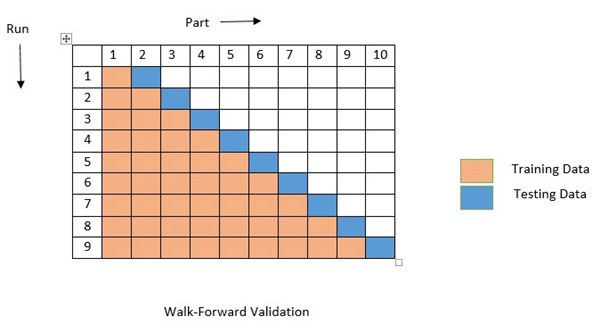


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from tqdm import tqdm

clf = GaussianNB()

#X = datadata.drop(columns = ['Open', 'High', 'Low', 'Close', 'SMA_15', 'SMA_100'], inplace = True)
n_train = 100
n_records = len(X)
pred = pd.DataFrame(index = df.index, columns = ['out', 'acuracia'])
acura = []

for i in tqdm(range(n_train+10, n_records-10)):
    #temos que tentar descobrir o i+10 pra nao ter vazamento de dados
    #sempre tera um gap entre o treino e o teste do tamanho da barreira vertical
    X_train, X_test = X[n_train:i], X[i+10:i+11]
    y_train, y_test = Y[n_train:i], Y[i+10:i+11]
    
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    
    #adicionando previsao
    pred.out[i+10:i+11] = y_pred
    
    acuracia = metrics.accuracy_score(y_test, y_pred)
    #adicionando acuracia
    pred.acuracia[i+10:i+11] = acuracia
    acura.append(acuracia) 
    #print('tMrain=%d, test=%d' % (len(X_train), len(X_test)))

100%|█████████████████████████████████████████████████████████████████████████████| 2606/2606 [00:08<00:00, 321.41it/s]


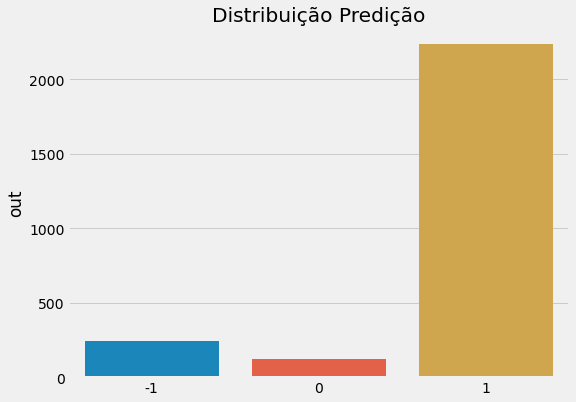

In [39]:
plt.rcParams["figure.figsize"] = (8,6)

sns.barplot(x = pred.out.value_counts().index, y = pred.out.value_counts())
plt.title('Distribuição Predição')
plt.show()

In [40]:
erros = pred.acuracia.value_counts()[0]
acertos = pred.acuracia.value_counts()[1]
total = erros + acertos

print('Acertos: {}%'.format(round(acertos/total*100, 2)))
print('Erros: {}%'.format(round(erros/total*100, 2)))

Acertos: 43.48%
Erros: 56.52%


$\quad$O modelo classificou a maioria dos dados como sinal de compra, o que era esperado, os sinais de venda e saída que preocupam por não estarem próximos da classificação da barreira tripla. \
$\quad$Nessa etapa tivemos 43.48% acertos, um desempenho baixo.


## Backtest
$\quad$ A implementação do backtest é autoral. Embasei no formato e na lógica do curso Quant Expert, de Rafael Lavrado, e implementei no python utilizando orientação a objeto. \
$\quad$Gerei as tabelas dos trades short e long e algumas estatísticas de performance da estratégia. \
$\quad$O codigo da implementação do backtest pode ser encontrado aqui [Backtest](https://github.com/mathsinis/mathsinis.github.io/blob/main/codigos/Backtest.py)


In [42]:
import Backtest as bt

In [43]:
out = pred.fillna(0).out
bt2 = bt.backtest(data.index, data.Close.values, out.values)

### Trades Long

In [44]:
b = bt2.trade_long()
print(b)

         trade    entrada      saida   ndias  perfomance
0      Trade 1 2010-07-02 2010-07-05  3 days   -0.024191
1      Trade 2 2010-07-20 2010-07-21  1 days   -0.003225
2      Trade 3 2010-07-22 2010-07-23  1 days    0.010499
3      Trade 4 2010-07-28 2010-08-30 33 days   -0.061846
4      Trade 5 2010-09-13 2010-09-15  2 days    0.020259
..         ...        ...        ...     ...         ...
189  Trade 190 2020-11-13 2020-11-16  3 days    0.035125
190  Trade 191 2020-11-19 2020-11-24  5 days    0.031239
191  Trade 192 2020-11-25 2020-11-27  2 days   -0.013624
192  Trade 193 2020-12-02 2020-12-10  8 days    0.052368
193  Trade 194 2020-12-11 2020-12-30 19 days    0.010543

[194 rows x 5 columns]


In [45]:
b.head()

,trade,entrada,saida,ndias,perfomance
0,Trade 1,2010-07-02,2010-07-05,3 days,-0.024191
1,Trade 2,2010-07-20,2010-07-21,1 days,-0.003225
2,Trade 3,2010-07-22,2010-07-23,1 days,0.010499
3,Trade 4,2010-07-28,2010-08-30,33 days,-0.061846
4,Trade 5,2010-09-13,2010-09-15,2 days,0.020259


In [46]:
bt2.long_info()


Perf Long

N Trades:194 
Win:96 
Acerto:49.48% 
Avg Win:5.27% 
Erro:-95% 
Avg Loss:-3.86%  
Avg Total:0.68%  
Avg Holding:17 days 00:14:50.721649484  
Avg Holding Win:21 days 00:30:00  
Avg Holding Loss:13 days 04:27:12.989690721


### Trades Short

In [97]:
s = bt2.trade_short()
print(s)

         trade    entrada      saida  ndias  performance
0      Trade 1 2010-07-06 2010-07-07 1 days     0.058635
1      Trade 2 2010-07-14 2010-07-20 6 days     0.003506
2      Trade 3 2010-07-21 2010-07-22 1 days     0.027231
3      Trade 4 2010-07-23 2010-07-28 5 days     0.023376
4      Trade 5 2010-08-30 2010-08-31 1 days     0.029116
..         ...        ...        ...    ...          ...
158  Trade 159 2020-10-23 2020-10-26 3 days     0.007076
159  Trade 160 2020-10-27 2020-11-03 7 days    -0.033533
160  Trade 161 2020-11-05 2020-11-06 1 days    -0.001173
161  Trade 162 2020-11-12 2020-11-13 1 days     0.018969
162  Trade 163 2020-11-17 2020-11-19 2 days    -0.023059

[163 rows x 5 columns]


In [98]:
bt2.short_info()


Perf Short

N Trades:163 
Win:79 
Acerto:48.47% 
Avg Win:2.73% 
Erro:51.53% 
Avg Loss:-1.72%  
Avg Total:0.45%  
Avg Holding:2 days 05:09:12.147239263  
Avg Holding Win:2 days 12:45:34.177215189  
Avg Holding Loss:1 days 22:15:54.216867469


Analisando as estatísticas, a estratégia divergiu bastante quanto a operação de long e short , com uma média de holding muito maior que o esperado(10 dias) para long e muito menor para short, quanto a performance, o resultado foi insatisfatório com um número de acertos baixo e com uma média do percentual de rendimento próximo a zero.

## Benchmark

Simulei o percentual de rendimento durante o período da estratégia e comparei com a IBOV

C:\Users\msini\Anaconda3\envs\finances\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


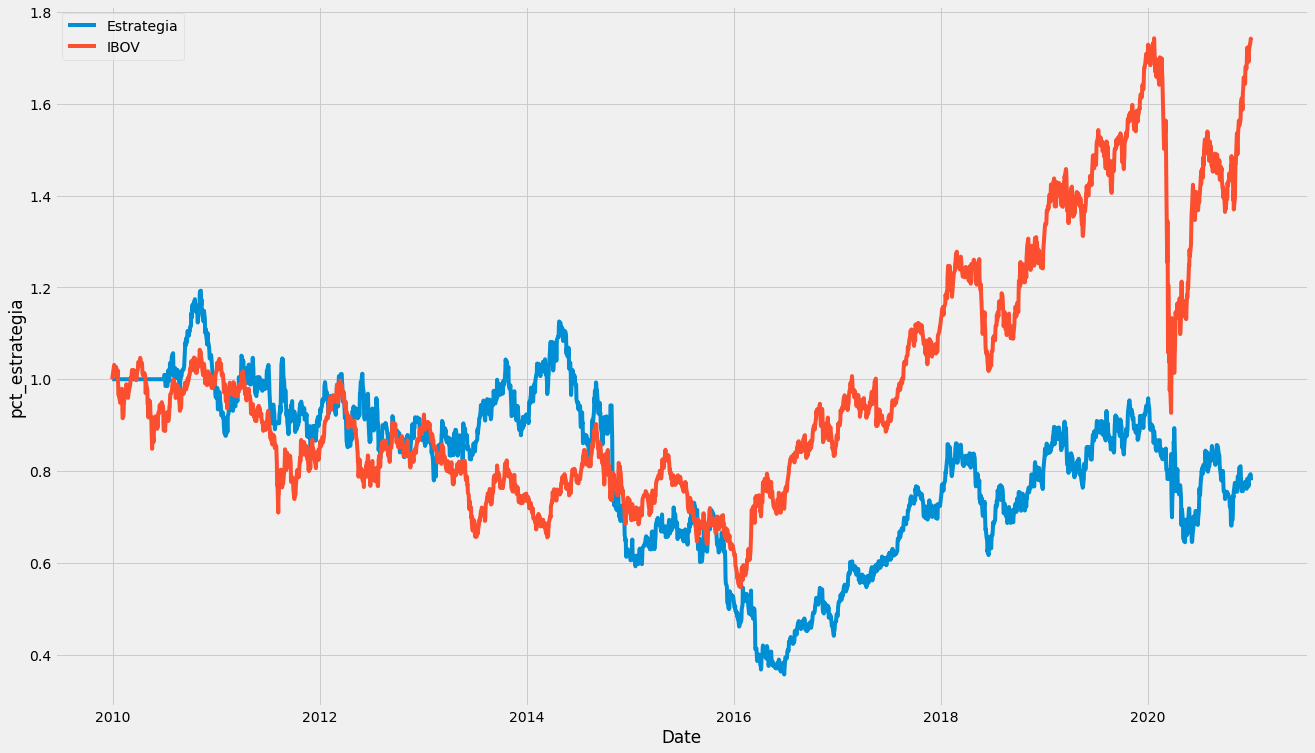

In [48]:
ticker = '^BVSP'
yfObj = yf.Ticker(ticker)
ibov = yfObj.history(start="2009-12-30", end="2020-12-31")

ibov['pct_change'] = ibov.Close.pct_change(1).fillna(0)

#acumulando
ibov_acum = []
#adicionando primeiro dia
ibov_acum.append(ibov['pct_change'][0]+1)
for i in range(1,len(ibov.Close)):
    ibov_acum.append((ibov['pct_change'][i]+1)*ibov_acum[i-1])

ibov_acum = pd.Series(ibov_acum, index = ibov.index)


out_s = pd.Series(out.values, index = data.index)

df2 = pd.DataFrame()
df2['out_s'] = out_s
df2['Close'] = data.Close.pct_change(1)
df2['Close'].iloc[0] = 0
df2['estrategia'] = df2['out_s'] * df2['Close']

est_acum = []
est_acum.append(1)

for i in range(1, len(df2['estrategia'])):
    est_acum.append((df2['estrategia'].iloc[i] + 1)*est_acum[i-1])

df2['pct_estrategia'] = est_acum

X = df2.index
y = df2.pct_estrategia

X2 = ibov_acum.index
y2 = ibov_acum

plt.rcParams["figure.figsize"] = (20,12)

p2 = sns.lineplot(x = X,y = y, label = 'Estrategia')
p3 = sns.lineplot(x = X2,y = y2, label = 'IBOV')

#p2, = plt.plot(X, df2.pct_estrategia, label = 'close', color = 'blue')
#p2, = plt.plot(X2, cdi_dia_acum.values, label = 'close', color = 'red')
#plt.legend(handles=[p0, p1, p3, p4])
plt.show()

Pela analise visual do desempenho da estratégia, verifica-se que no geral, ela não conseguiu ultrapassar a IBOV e retornou em prejuízo ao final do período. O único período que parece dar bons retornos ocorreu por volta de 2014

## Conclusão

$\quad$A estratégia de investimento apresentada não obteve um resultado satisfatório. Diversos motivos podem ter contribuído para esse desempenho: base de dados pobre e com quantidade de dados insatisfatória, indicadores insuficientes e até mesmo os modelos selecionados podem não ter sido os melhores para esse tipo de problema. Diferentes tipos de abordagem dentro desse trabalho podem acabar gerando resultados melhores, desde a busca de uma base de dados mais próxima da realidade até modelos de complexidade maior (aprendizado profundo).

## Bibliografia

De Prado, M. L. (2018). Advances in financial machine learning. John Wiley & Sons.

Gui, K. (30 de Agosto de 2020). Data Labelling: The Triple-barrier Method. Fonte: Towards Data Science: https://towardsdatascience.com/the-triple-barrier-method-251268419dcd

Quant Expert: Estratégias Quantitativas. Rafael Lavrado: https://www.udemy.com/course/quant-expert/
